<a href="https://colab.research.google.com/github/GonzaloRomeroR/CEIA/blob/master/vision_computadora_2/clase_3/VPC2_clase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio: clase 3

Utilizando otro dataset, realizar transfer learning de otras arquitecturas disponibles y comparar resultados.

## Download dataset

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get kaggle json file
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10 -p "./drive/My Drive/datasets/Animals-10"

animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!kaggle datasets list -s Animals-10

ref                                                           title                                         size  lastUpdated          downloadCount  
------------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
alessiocorrado99/animals10                                    Animals-10                                   586MB  2019-12-12 20:46:33          18870  
agajorte/zoo-animals-extended-dataset                         Zoo Animals Extended Dataset                   2KB  2019-06-02 16:22:31           3029  
viratkothari/animal10                                         Animals-10                                   585MB  2020-09-17 18:56:19            441  
vishweshsalodkar/wild-animals                                  Wild Animals                                  7MB  2021-07-29 16:48:17            305  
iamsouravbanerjee/animal-image-dataset-90-different-animals   Animal Image Dataset (90 Differe

In [ ]:
!kaggle datasets download -h

usage: kaggle datasets download [-h] [-f FILE_NAME] [-p PATH] [-w] [--unzip]
                                [-o] [-q]
                                [dataset]

optional arguments:
  -h, --help            show this help message and exit
  dataset               Dataset URL suffix in format <owner>/<dataset-name> (use "kaggle datasets list" to show options)
  -f FILE_NAME, --file FILE_NAME
                        File name, all files downloaded if not provided
                        (use "kaggle datasets files -d <dataset>" to show options)
  -p PATH, --path PATH  Folder where file(s) will be downloaded, defaults to current working directory
  -w, --wp              Download files to current working path
  --unzip               Unzip the downloaded file. Will delete the zip file when completed.
  -o, --force           Skip check whether local version of file is up to date, force file download
  -q, --quiet           Suppress printing information about the upload/download progress


In [ ]:
import os
os.chdir('./drive/My Drive/datasets/Animals-10') 
!unzip -q animals10.zip -d animals10


replace animals10/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Load data

In [2]:
# Import libraries
import torch
from torch import nn
import pandas as pd
import time
import os
import copy
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
import torchvision.datasets as datasets
from torchvision import transforms, models
import torchvision
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler


In [3]:
# Load data
os.chdir('./drive/My Drive/datasets/Animals-10') 
DIRECTORY = './animals10/raw-img/'
dataset = datasets.ImageFolder(DIRECTORY)


train_size = int(len(dataset) * 0.8)
val_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - val_size

train, val, test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

reduce = 0.1
train = Subset(train, np.arange(int(train_size * reduce)))
val = Subset(val, np.arange(int(val_size * reduce)))
test = Subset(test, np.arange(int(test_size * reduce)))


In [4]:
# Se definen las transformaciones para hacer data augmentation
torchvision_transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(360),
    transforms.ToTensor(),
    
])

In [5]:
# Se define el dataset
class CustomDataset(Dataset):
  def __init__(self, dataset, transform=None):
    super().__init__()
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    x = self.dataset[idx][0]
    if self.transform:
      x = self.transform(x)
    y = self.dataset[idx][1]
    return x, y
     

In [6]:
# Se definen los parámetros de entrenamiento
params = {'batch_size': 64,
          'shuffle': True,}

# Se generan los datasets y dataloaders
train_set = CustomDataset(train, torchvision_transform)
val_set = CustomDataset(val, torchvision_transform)
test_set = CustomDataset(test, torchvision_transform)

train_loader = torch.utils.data.DataLoader(train_set, **params)
val_loader = torch.utils.data.DataLoader(val_set, **params)
test_loader = torch.utils.data.DataLoader(test_set, **params)

In [7]:
len(train_set)

2094

In [8]:
def idx_to_class(idx_dict, value):
  inv_dict = {v: k for k, v in idx_dict.items()}
  return inv_dict[value]

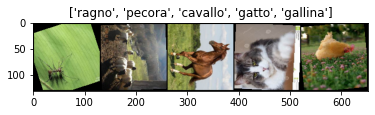

In [9]:
# Se imprimen algunas imágenes
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

num_images = 5

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:num_images])
imshow(out, title=[idx_to_class(dataset.class_to_idx, value.item()) for value in classes[:num_images]])

In [10]:
# Create model

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        for param in self.resnet18.parameters():
          param.requires_grad = False
        self.fc1 = nn.Linear(1000, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.resnet18(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [11]:
model = Net()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [61]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,820,646 total parameters.
131,134 training parameters.


In [13]:
dataloaders = {"train": train_loader, "val": val_loader,}
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [16]:
# Se entrena el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
  model.cuda()
losses_train = []
losses_val = []
running_loss = 0.0
for epoch in range(50):
    model.train()
    running_loss = 0.0
    correct = 0
    correct_val = 0
    model = model.train()
    for i, data in enumerate(dataloaders["train"]):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        _, preds = torch.max(outputs, 1)
        optimizer.step()
        running_loss += loss.item()
        correct += (preds == labels).float().sum()
    model = model.eval() 
    with torch.no_grad():
      valid_loss = 0.0
      for i, data in enumerate(dataloaders["val"]):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          valid_loss += loss.item()
          _, preds = torch.max(outputs, 1)
          correct_val += (preds == labels).float().sum()


    print('[%d] training loss: %.5f, validation loss: %.5f' %(epoch + 1, running_loss / len(train_loader), valid_loss / len(val_loader)), end="")
    print(", train accuracy {}, val accuracy {}".format(100 * correct / len(train_set), 100 * correct_val / len(val_set)))
    losses_train.append(running_loss / len(train_loader))
    losses_val.append(valid_loss / len(val_loader))

cuda
[1] training loss: 1.27098, validation loss: 1.28484, train accuracy 57.16332244873047, val accuracy 59.38697052001953
[2] training loss: 1.12595, validation loss: 0.98277, train accuracy 61.843360900878906, val accuracy 59.77011489868164
[3] training loss: 1.13118, validation loss: 1.09271, train accuracy 61.652339935302734, val accuracy 65.90038299560547
[4] training loss: 1.10692, validation loss: 1.19536, train accuracy 62.5596923828125, val accuracy 63.218387603759766
[5] training loss: 1.09752, validation loss: 1.31371, train accuracy 62.7984733581543, val accuracy 63.98467254638672
[6] training loss: 1.04930, validation loss: 0.91314, train accuracy 64.56542205810547, val accuracy 65.90038299560547
[7] training loss: 1.06260, validation loss: 1.03240, train accuracy 63.75358200073242, val accuracy 62.83524703979492
[8] training loss: 1.03817, validation loss: 1.03282, train accuracy 65.09073638916016, val accuracy 63.218387603759766
[9] training loss: 1.07223, validation lo

Text(0.5, 0, 'epoch')

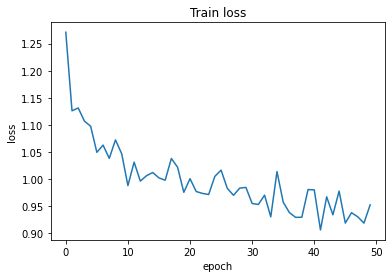

In [17]:
# Se grafica el error de entrenamiento
plt.plot(losses_train)
plt.title("Train loss")
plt.ylabel("loss")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

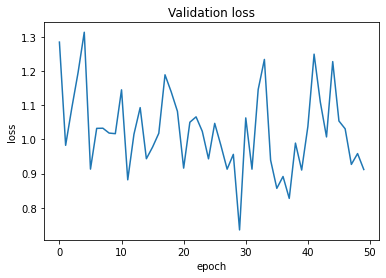

In [18]:
# Se grafica el error de validación
plt.plot(losses_val)
plt.title("Validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")

In [56]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network test images: {:.2f}'.format(correct / total))

Accuracy of the network test images: 0.62


In [60]:
classes = test.dataset.dataset.classes
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.2f}".format(classname, accuracy))

Accuracy for class cane  is: 84.91
Accuracy for class cavallo is: 31.82
Accuracy for class elefante is: 61.54
Accuracy for class farfalla is: 74.07
Accuracy for class gallina is: 83.87
Accuracy for class gatto is: 23.81
Accuracy for class mucca is: 52.63
Accuracy for class pecora is: 61.11
Accuracy for class ragno is: 81.58
Accuracy for class scoiattolo is: 47.37
